# DAISY RNAseq data projection

This notebook project RNA sequencing data into a Latent Space representing gene modules that are co expressed given various conditions, cell types, ... 

Sakaiza Rasolofomanana Rajery

12/19/2024

## load packages

In [1]:
library(tidyverse,warn.conflicts=FALSE)
library(reticulate)
library(MASS,warn.conflicts=FALSE)
library(devtools,warn.conflicts=FALSE)
library(PLIER,warn.conflicts=FALSE)
library(reticulate)
library("ggpubr")
#install_github("wgmao/PLIER")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: usethis

Loading required package: RColorBrewer

Loading required package: gplots


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Loading required package: pheatmap

Loading required package: glmnet

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

Loading required package: knit

In [2]:
# srouce plier_util to get function GetnewdataB 
source('scripts/plier_util.R')

In [3]:
# use GetOrderedRowNormEM function from Marc to order matrices
GetOrderedRowNormEM <- function(exprs.mat, plier.model) {

    require(PLIER)
    
    # Z-score normalization
    exprs.norm <- rowNorm(exprs.mat)
    exprs.norm <- na.omit(exprs.norm)
    
    z.mat <- plier.model$Z
    genes.in.model <- rownames(z.mat)
    genes_in_exprs <- rownames(exprs.norm)
    
    # Find the common genes
    common_genes <- intersect(genes_in_exprs, genes.in.model)
    
    # Filter the matrices based on the common genes
    exprs.norm.filtered <- exprs.norm[common_genes, , drop = FALSE]
    z.mat.filtered <- z.mat[common_genes, , drop = FALSE]
        
  # Update the plier.model with the new Z matrix
  plier.model$Z <- z.mat.filtered

  # Return the updated plier.model and the filtered exprs.norm
  list(plier.model = plier.model, exprs.norm.filtered = exprs.norm.filtered)

}

## load data: RNA seq, Matrices, name to ID, metada

### RNA_seq data: chose visit timepoint 1 or 2 or timepoint difference

In [21]:
#tp <- "1"
tp <- "2" 
#tp <- "diff"

### load data

In [22]:
# path to rna dataset
path_to_rna <- "/Users/rasolofs/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/DAISY RNA Phenoplier"

In [23]:
# create difference dataset and save in RNA Daisy folder on drive (just run once)

#RNAseq_1_res <- as.matrix(readRDS(paste0(path_to_rna,"/RNA_Visit_2_Residuals.RDS")))
#RNAseq_2_res <- as.matrix(readRDS(paste0(path_to_rna,"/RNA_Visit_1_Residuals.RDS")))
#RNAseq_diff <- RNAseq_2_res - RNAseq_1_res

#saveRDS(RNAseq_diff,paste0(path_to_rna,"/RNA_Visit_diff_Residuals.RDS")) 

In [24]:
#raw value at visit 1 and 2
#RNAseq_1_Raw <- readRDS("RNA_Visit_1.RDS")
#RNAseq_2_Raw <- readRDS("RNA_Visit_2.RDS")

#r-log adjusted for age, sex and ancestry at visit 1 and 2
RNAseq_data <- as.matrix(readRDS(paste0(path_to_rna,"/RNA_Visit_",tp,"_Residuals.RDS")))



#RNA_annot <- readRDS("Expression_Annotation.RDS")
#RNA_pheno <- read_csv("DAISY_RNASeq_Phenotype_Deidentified.csv")

str(RNAseq_data)
head(RNAseq_data,5)
dim(RNAseq_data)

 num [1:22236, 1:136] -0.1262 0.1554 0.0615 0.3482 0.1911 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:22236] "ENSG00000000003" "ENSG00000000419" "ENSG00000000457" "ENSG00000000460" ...
  ..$ : chr [1:136] "00041-0" "00110-0" "00139-0" "00159-0" ...


,00041-0,00110-0,00139-0,00159-0,00174-0,00177-0,00181-0,00234-0,00250-0,00266-0,⋯,39376-0,39390-0,50136-0,62291-0,81801-0,84002-0,84689-0,84731-0,84860-0,85365-0
ENSG00000000003,-0.12624165,-0.159462038,0.49575958,-0.04359223,-0.03125802,-0.14254590,-0.11348927,-0.17195202,0.08962260,-0.09240144,⋯,0.0370263495,-0.05902015,0.25369279,0.02727655,-0.16851862,0.005054743,-0.19149807,-0.09908251,-0.000448132,-0.17540402
ENSG00000000419,0.15543093,-0.223865340,-0.15793771,-0.16148734,-0.19706395,0.31335105,0.18484131,-0.04994325,0.28942191,-0.01103464,⋯,-0.1695997239,0.04123930,0.08184702,-0.02161203,0.30071225,-0.061131543,0.09630378,0.01382037,-0.230090659,-0.06163213
ENSG00000000457,0.06153277,0.009822344,0.01112568,-0.14907194,-0.02693839,-0.35424145,-0.16040883,-0.01268009,-0.02455520,-0.11231145,⋯,-0.1253767603,0.11251813,0.02054370,-0.11409450,0.02699623,0.120364830,0.15134030,0.04457402,-0.236675720,-0.31096022
ENSG00000000460,0.34821021,0.169711091,0.14150941,0.20141003,0.07123779,0.65416427,0.04871970,0.05499721,0.05762413,0.13184903,⋯,-0.2394024888,-0.04206933,-0.02954034,0.10709581,-0.08125212,-0.130261516,-0.27357840,0.03304613,0.070908915,0.18260665
ENSG00000000938,0.19107804,-0.125299403,-0.07822936,-0.18449955,0.03978983,-0.08463978,0.05333766,0.04011615,0.15721805,0.02508208,⋯,-0.0006519936,-0.14799119,-0.29089623,-0.24670785,0.12345756,0.101731154,0.10853952,0.24243226,0.205704726,-0.16158158


[1] 22236   136

### name to ensemble_id file

In [25]:
#load pickle data to convert gene name to EnsemblID
py_data <- py_load_object("data/input/genes_mapping_id_to_name.pkl")
data_t <- data.frame(t(data.frame(py_data)))
colnames(data_t) <- "gene"
name_to_ID <- rownames_to_column(data_t, var = "EnsemblID")
head(name_to_ID,5)

,EnsemblID,gene
,<chr>,<chr>
1,ENSG00000000457,SCYL3
2,ENSG00000000938,FGR
3,ENSG00000000971,CFH
4,ENSG00000001036,FUCA2
5,ENSG00000001084,GCLC


### metadata file

In [26]:
# Import model metadata file to re-build plier model
metadata <- readRDS("data/input/multiplier_model_metadata.rds")
print(metadata)

$L1
[1] 120.5661

$L2
[1] 241.1322

$L3
[1] 0.01269676



### Multiplier matrices

In [27]:
# load matrices to rebuild plier model
# LV x samples
b_model <- readRDS("data/input/multiplier_model_b.rds")
head(b_model,5)
# gene x LV
z_model <- readRDS("data/input/multiplier_model_z.rds")
head(z_model,5)

,SRP000599.SRR013549,SRP000599.SRR013550,SRP000599.SRR013551,SRP000599.SRR013552,SRP000599.SRR013553,SRP000599.SRR013554,SRP000599.SRR013555,SRP000599.SRR013556,SRP000599.SRR013557,SRP000599.SRR013558,⋯,SRP035599.SRR1139372,SRP035599.SRR1139393,SRP035599.SRR1139388,SRP035599.SRR1139378,SRP035599.SRR1139399,SRP035599.SRR1139386,SRP035599.SRR1139375,SRP035599.SRR1139382,SRP035599.SRR1139356,SRP035599.SRR1139370
"1,REACTOME_MRNA_SPLICING",-0.059296689,-0.047909034,-0.049366085,-0.065078034,-0.036394186,-0.046432986,-0.040980500,-0.040068202,-0.046137392,-0.048547681,⋯,0.028219530,0.035137107,0.065077330,0.078143650,0.092361864,0.069042346,0.090913845,0.096341467,0.13111465,0.171751422
"2,SVM Monocytes",0.006212678,0.003625471,0.006604582,0.009258006,0.005061427,0.004132735,0.008950264,0.007226716,0.007240987,0.005709697,⋯,-0.050455152,-0.034501970,-0.033640290,-0.049702173,-0.037425739,-0.050069528,-0.022575052,-0.055091302,-0.05686929,-0.018072570
"3,REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES",-0.026105335,-0.032232060,-0.020621382,-0.027598555,-0.035248076,-0.038700769,-0.032527087,-0.030592727,-0.028937277,-0.027405660,⋯,-0.028609689,-0.033449754,-0.030583001,-0.032399106,-0.029365381,-0.025405876,-0.033657228,-0.031317680,-0.03092424,-0.027868614
"4,REACTOME_NEURONAL_SYSTEM",-0.022079745,-0.008970910,-0.020341711,-0.016260213,-0.003022898,0.002442659,-0.020457842,-0.023735309,-0.021581483,-0.022477572,⋯,-0.037122216,-0.029658154,-0.036349546,-0.039253549,-0.035204624,-0.036345061,-0.034513880,-0.035925708,-0.04035837,-0.031131153
LV 5,0.007663157,0.007036176,0.006608393,0.003446311,0.006340665,0.007106127,0.007930485,0.009164026,0.008023601,0.007937586,⋯,-0.003055909,-0.004783739,-0.004352417,-0.004159541,-0.001084991,-0.001884109,-0.003561052,-0.003546184,-0.01210732,-0.001192709


GAS6,0.0000000,0,0.03943774,0,0.05047625,0.00000000,0,0.000000000,0.5909494,0.00000000,⋯,0.05012510,0.00000000,0.033407371,0.00000000,0.00000000,0.005963392,0.34736209,0,0.00000000,0.0000000
MMP14,0.0000000,0,0.00000000,0,0.07007159,0.00000000,0,0.004904131,1.7201788,2.42359463,⋯,0.00000000,0.00000000,0.001007286,0.00000000,0.03574724,0.000000000,0.00000000,0,0.01497801,0.0000000
DSP,0.0000000,0,0.00000000,0,0.00000000,0.04169683,0,0.005718149,0.0000000,0.00000000,⋯,0.02085321,0.00000000,0.000000000,0.00000000,0.00000000,0.005774440,0.00000000,0,0.00000000,0.4164045
MARCKSL1,0.3052117,0,0.00000000,0,0.00000000,0.00000000,0,0.000000000,0.1618435,0.14947148,⋯,0.02713418,0.05271997,0.000000000,0.03018947,0.06088351,0.000000000,0.00000000,0,0.00000000,0.4484800
SPARC,0.0000000,0,0.00000000,0,0.00000000,0.00000000,0,0.000000000,0.0000000,0.01401441,⋯,0.00000000,0.00000000,0.000000000,0.00000000,0.00000000,0.000000000,0.06777859,0,0.12241734,0.0626649


In [28]:
# importing phenotype file
RNA_pheno <- read_csv(paste0(path_to_rna,"/DAISY_RNASeq_Phenotype_Deidentified.csv"), col_types = cols())
dim(RNA_pheno)
head(RNA_pheno,1)
# see how many people among 136 were maintainer, reverter, progresser. 
patient_per_group <- RNA_pheno%>%
group_by(Group)%>%
summarize(n= n())

patient_per_group

[1] 136  22

ID,Group,Freezer_Time,Female_YN,Multiple_DAISY_Baseline,S_W,NHW_YN,dr34_YN,FDR_YN,Age,⋯,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
00041-0,Maintainer,11.6797,0,0,0.7595215,1,1,1,17.1307,⋯,-0.0067,-0.0068,0.0137,-0.0646,0.0774,-0.004,-6e-04,-0.1208,-0.0602,0.0387


Group,n
<chr>,<int>
Maintainer,64
Progressor,25
Reverter,47


## label z_matrix with ensemblID instead of gene name

In [29]:
# convert matrix to dataframe with gene as rownames
z_df <- cbind(gene = rownames(z_model), as.data.frame(z_model))
# merge dataframe with 'name_to_ID' (file containing name and ensembleID) by gene
EnsID_df <- merge(z_df, name_to_ID, by = "gene")
#set rownames of new dataframe to ensembleID
rownames(EnsID_df) <- EnsID_df$EnsemblID
#remove gene and ensembleID column
z_matrix <- as.matrix(EnsID_df[, !(colnames(EnsID_df) %in% c("gene", "EnsemblID"))])

str(z_matrix)
head(z_matrix,5)
dim(z_matrix)

 num [1:6455, 1:987] 0 0.2712 0.0051 0.513 1.0082 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:6455] "ENSG00000175899" "ENSG00000094914" "ENSG00000129673" "ENSG00000090861" ...
  ..$ : chr [1:987] "V1" "V2" "V3" "V4" ...


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V978,V979,V980,V981,V982,V983,V984,V985,V986,V987
ENSG00000175899,0.000000000,0.0000000,0.00000000,0.07842750,0,0.0000000,0.0000000,0.04677228,0.0000000,0.0110329,⋯,0.010910,0.00000000,0.052869436,0.012748534,0,0.01398231,0.15224090,0.00000000,0.0000000,0.10888358
ENSG00000094914,0.271162234,0.0000000,0.00000000,0.00000000,0,0.0000000,0.0000000,0.00000000,1.5133366,0.0000000,⋯,0.000000,0.00000000,0.000000000,0.001385031,0,0.00000000,0.71189565,0.03053447,0.4471055,0.42468522
ENSG00000129673,0.005098885,0.3084969,0.02881539,0.00000000,0,0.0000000,0.3717253,0.00000000,0.1352375,0.0000000,⋯,0.117163,0.01881498,0.000000000,0.193141835,0,0.04040077,0.18043565,0.00000000,0.0000000,0.04206449
ENSG00000090861,0.512978085,0.0000000,0.45128547,0.31956792,0,0.0000000,0.0000000,0.00000000,0.0000000,0.0000000,⋯,0.000000,0.00000000,0.006207784,0.021274385,0,0.00000000,0.06214269,0.00000000,0.0000000,0.36489213
ENSG00000124608,1.008156895,0.0000000,0.19742406,0.02483182,0,0.5708101,0.0000000,0.22867460,0.0000000,0.1162435,⋯,0.000000,0.00000000,0.153344992,0.000000000,0,0.00000000,1.00457811,0.01447016,0.0000000,0.00000000


[1] 6455  987

In [30]:
# rebuild plier model with z, b, L1, L2, L3
plier.model <- list(Z = z_matrix, B =b_model, L1 = metadata$L1, L2 = metadata$L2, L3 = metadata$L3)

In [31]:
# Check all variables are loaded
ls()

[1] "b_model"                      "CalculateHoldoutAUC"         
 [3] "CalculateUSparsity"           "comp_i"                      
 [5] "data_t"                       "df_projection"               
 [7] "EnsID_df"                     "EvalWrapper"                 
 [9] "EvalWrapperWithHoldout"       "GetNewDataB"                 
[11] "GetOrderedRowNorm"            "GetOrderedRowNormEM"         
[13] "GetPathwayCoverage"           "GetReconstructedExprs"       
[15] "GetReconstructionCorrelation" "GetReconstructionMASE"       
[17] "i"                            "LV_names"                    
[19] "metadata"                     "name_to_ID"                  
[21] "ordered_DAISY_gen_expr"       "ordered_mat"                 
[23] "ordered_model"                "path_to_rna"                 
[25] "patient_per_group"            "plier.model"                 
[27] "PLIERNewData"                 "projection"                  
[29] "py_data"                      "remove_dot"                  
[31] "remove_pathway"               "res"                         
[33] "res_formated"                 "RNA_pheno"                   
[35] "RNA_proj"                     "RNA_proj_group"              
[37] "RNA_proj_t"                   "RNAseq_data"                 
[39] "tp"                           "z_df"                        
[41] "z_matrix"                     "z_model"

In [32]:
#order gene expression matrix to match plier model
ordered_mat <- GetOrderedRowNormEM(RNAseq_data, plier.model)

#extract gene_expressiom matrix
ordered_DAISY_gen_expr <- ordered_mat$exprs.norm.filtered

# extract plier model matrix
ordered_model <- ordered_mat$plier.model

In [33]:
#project gen expression matrix into plier model
projection <- GetNewDataB(ordered_DAISY_gen_expr,ordered_model)

In [34]:
#save projection
df_projection  <- as.data.frame(projection)
saveRDS(df_projection,paste0("output/projection_",tp,".rds"))

In [35]:
dim(df_projection)

[1] 987 136

In [36]:
head(df_projection, 10)

,00041-0,00110-0,00139-0,00159-0,00174-0,00177-0,00181-0,00234-0,00250-0,00266-0,⋯,39376-0,39390-0,50136-0,62291-0,81801-0,84002-0,84689-0,84731-0,84860-0,85365-0
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"1,REACTOME_MRNA_SPLICING",-0.065654002,-0.011991253,-0.007941819,-0.0004729541,0.086384408,0.102794024,-0.086708544,-0.008380002,-0.02527753,0.0077265706,⋯,-0.0048957637,-0.021413500,0.019072135,-0.035586294,-0.050849695,0.059383645,0.0404165535,0.026432658,-0.082480839,0.021614799
"2,SVM Monocytes",0.126126594,0.058097739,0.011168935,-0.1308531502,-0.014337653,-0.204829274,0.044596842,0.046811858,0.05674640,0.2406728139,⋯,-0.0144352155,-0.180009277,-0.064981194,-0.117902627,0.061725090,0.004906946,-0.0212953989,0.002720316,0.145421375,0.072369974
"3,REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES",0.019228724,-0.019702831,-0.012215432,0.0374060365,-0.006672154,-0.019227900,0.022800206,-0.067181949,0.01074369,0.0020014708,⋯,0.0254999115,-0.029614147,0.006423163,0.002997441,0.004411272,-0.012225357,0.0704166671,0.054572137,-0.002762467,-0.017913798
"4,REACTOME_NEURONAL_SYSTEM",-0.011399020,0.039376590,-0.053492638,-0.0450244884,0.008482421,0.009478947,0.028363725,0.032129075,-0.01016232,-0.0007266422,⋯,0.0397401446,0.051093978,0.006980890,0.060360282,-0.032277400,0.006921357,-0.1833113360,-0.129591839,0.057097744,0.062284114
LV 5,-0.001128021,0.005785657,0.054724185,-0.0051077911,0.032131432,0.054426288,0.014873787,-0.024274848,0.01308706,-0.0319751005,⋯,-0.0009992844,-0.001544452,-0.008667028,0.026155623,0.010000537,-0.030346409,-0.0534199156,-0.013347874,-0.029368196,-0.025200609
LV 6,0.026634379,0.021931900,-0.024917800,0.0056375585,0.019438941,0.021972458,-0.007656666,-0.018120707,-0.04881705,-0.0475428257,⋯,0.0075362817,0.011127855,-0.013542777,0.026155077,-0.022934801,0.032449164,-0.0442926103,-0.005756487,0.004111217,0.036410240
"7,IRIS_Neutrophil-Resting",0.055149666,-0.139316035,-0.028067632,-0.0507662816,0.002389750,-0.082315034,0.059581291,0.031927425,0.12942321,-0.0619625581,⋯,0.0589991158,-0.101291433,-0.051797144,-0.138021896,0.051861900,0.159618902,0.0508211900,0.149324954,0.089900154,-0.184373496
"8,KEGG_PPAR_SIGNALING_PATHWAY",0.010203424,-0.015773584,-0.014142454,-0.0225466497,0.009314969,0.048261852,-0.024134138,-0.022470833,-0.02220176,0.0032112437,⋯,0.0138169595,-0.009242867,-0.037450039,0.011091459,0.079059915,0.046487179,-0.0004278238,0.011696228,-0.005042048,-0.010868487
LV 9,-0.006378183,-0.099178794,-0.017852051,0.0363158445,-0.015259546,-0.044389280,-0.039563712,-0.045725956,0.06184638,0.0318330282,⋯,0.0030970816,-0.059448917,-0.017083178,-0.008269152,0.041755391,-0.058570855,0.1505511503,0.129004562,-0.003036230,-0.058032085


[1] 987 136

,00041-0,00110-0,00139-0,00159-0,00174-0,00177-0,00181-0,00234-0,00250-0,00266-0,⋯,39376-0,39390-0,50136-0,62291-0,81801-0,84002-0,84689-0,84731-0,84860-0,85365-0
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"1,REACTOME_MRNA_SPLICING",-0.065654,-0.01199125,-0.007941819,-0.0004729541,0.08638441,0.102794,-0.08670854,-0.008380002,-0.02527753,0.007726571,⋯,-0.004895764,-0.0214135,0.01907214,-0.03558629,-0.0508497,0.05938364,0.04041655,0.02643266,-0.08248084,0.0216148


[1] 987

,X1.REACTOME_MRNA_SPLICING,X2.SVM.Monocytes,X3.REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES,X4.REACTOME_NEURONAL_SYSTEM,LV.5,LV.6,X7.IRIS_Neutrophil.Resting,X8.KEGG_PPAR_SIGNALING_PATHWAY,LV.9,X10.SVM.Macrophages.M0,⋯,LV.978,LV.979,LV.980,LV.981,LV.982,LV.983,LV.984,X985.IRIS_Neutrophil.Resting,LV.986,LV.987
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
00041-0,-0.065654,0.1261266,0.01922872,-0.01139902,-0.001128021,0.02663438,0.05514967,0.01020342,-0.006378183,0.02719363,⋯,-0.03644017,-0.02230501,0.005917726,0.0004019891,0.003337531,-0.05066734,-0.1629861,0.05841612,-0.01853552,-0.03576809


,ID,"1,REACTOME_MRNA_SPLICING","2,SVM Monocytes","3,REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES","4,REACTOME_NEURONAL_SYSTEM",LV 5,LV 6,"7,IRIS_Neutrophil-Resting","8,KEGG_PPAR_SIGNALING_PATHWAY",LV 9,⋯,LV 979,LV 980,LV 981,LV 982,LV 983,LV 984,"985,IRIS_Neutrophil-Resting",LV 986,LV 987,Group
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,00041-0,-0.0656540020748254,0.126126593924544,0.0192287236433338,-0.0113990196253673,-0.00112802124455745,0.02663437902649,0.0551496662069748,0.010203424175125,-0.00637818261513064,⋯,-0.0223050097900997,0.00591772633462482,0.000401989064205315,0.00333753098784164,-0.0506673394294835,-0.162986078915122,0.05841612146097,-0.0185355219051451,-0.0357680900948522,Maintainer


,ID,X1.REACTOME_MRNA_SPLICING,X2.SVM.Monocytes,X3.REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES,X4.REACTOME_NEURONAL_SYSTEM,LV.5,LV.6,X7.IRIS_Neutrophil.Resting,X8.KEGG_PPAR_SIGNALING_PATHWAY,LV.9,⋯,LV.979,LV.980,LV.981,LV.982,LV.983,LV.984,X985.IRIS_Neutrophil.Resting,LV.986,LV.987,Group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,00041-0,-0.065654,0.1261266,0.01922872,-0.01139902,-0.001128021,0.02663438,0.05514967,0.01020342,-0.006378183,⋯,-0.02230501,0.005917726,0.0004019891,0.003337531,-0.05066734,-0.1629861,0.05841612,-0.01853552,-0.03576809,Maintainer


,ID,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,⋯,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987,Group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>
1,00041-0,-0.0656540021,0.12612659,0.019228724,-0.011399020,-0.001128021,0.026634379,0.05514967,0.010203424,-0.006378183,⋯,-0.022305010,0.005917726,0.0004019891,0.0033375310,-0.050667339,-0.1629861,0.0584161215,-0.01853552,-0.03576809,Maintainer
2,00110-0,-0.0119912530,0.05809774,-0.019702831,0.039376590,0.005785657,0.021931900,-0.13931604,-0.015773584,-0.099178794,⋯,-0.007911956,0.034845859,-0.0034088006,-0.0060667331,-0.012428251,-0.2021776,0.1333178029,-0.01727092,-0.02393074,Reverter
3,00139-0,-0.0079418188,0.01116893,-0.012215432,-0.053492638,0.054724185,-0.024917800,-0.02806763,-0.014142454,-0.017852051,⋯,0.038738802,0.017524122,0.0310289279,-0.0032984364,0.057692616,0.1181355,-0.0508902746,0.01250523,-0.04489453,Reverter
4,00159-0,-0.0004729541,-0.13085315,0.037406037,-0.045024488,-0.005107791,0.005637558,-0.05076628,-0.022546650,0.036315845,⋯,-0.022820960,0.012538255,-0.0180196478,-0.0202040898,0.008723508,0.1119591,-0.1393104869,0.03684806,0.07024293,Maintainer
5,00174-0,0.0863844084,-0.01433765,-0.006672154,0.008482421,0.032131432,0.019438941,0.00238975,0.009314969,-0.015259546,⋯,-0.013129918,0.007182440,0.0007084990,0.0004616102,-0.022940806,-0.1669717,0.0001026175,-0.01991626,0.08425170,Progressor


LV,p_val,fdr
<chr>,<dbl>,<dbl>
LV1,0.99057594,0.9987431
LV2,0.01358021,0.4718064
LV3,0.72056582,0.9401473
LV4,0.37394706,0.8786550
LV5,0.72618248,0.9401473


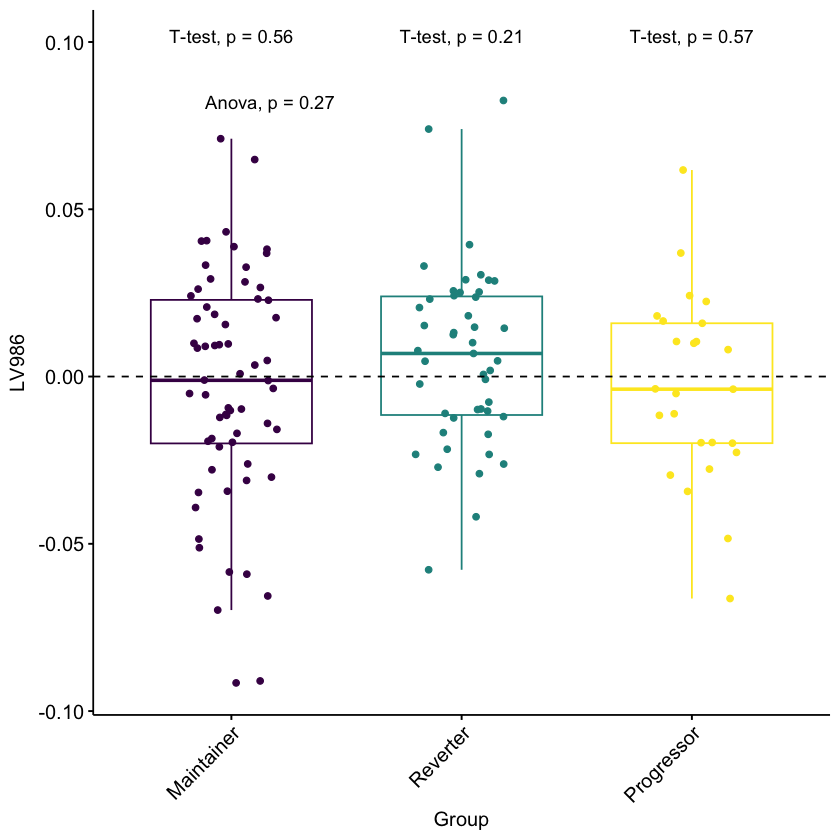

In [37]:
# importing results from projection og DAISY RNAseq visit 1 into Phenoplier latent space
#RNA_proj <- readRDS("output/projection_1.rds")
RNA_proj <- readRDS(paste0("output/projection_",tp,".rds"))
dim(RNA_proj)
head(RNA_proj,1)


# transposing projection output data to get LV names, check we have 987 LV
RNA_proj_t <- data.frame(t(RNA_proj))
LV_names <- colnames(RNA_proj_t)
length(LV_names)
head(RNA_proj_t,1)

# convert matrix to dataframe with gene as rownames
RNA_proj_t <- cbind(ID = colnames(RNA_proj), t(RNA_proj))
# merge transposed RNA projection output with each individual's T1D groupping
RNA_proj_group <- merge(RNA_proj_t, RNA_pheno[,1:2], by = "ID")

head(RNA_proj_group,1)
#set rownames of new dataframe to ensembleID
#rownames(EnsID_df) <- EnsID_df$EnsemblID
#remove gene and ensembleID column
#z_matrix <- as.matrix(EnsID_df[, !(colnames(EnsID_df) %in% c("gene", "EnsemblID"))])

colnames(RNA_proj_group)[2:988] <- LV_names
#this <- RNA_proj_group[,LV_col]
#convert all LV col into numeric
RNA_proj_group[,LV_names] <- sapply(RNA_proj_group[,LV_names], function(x) as.numeric(as.character(x)))
head(RNA_proj_group,1) 

                                    # order groupping factor
RNA_proj_group$Group <- ordered(RNA_proj_group$Group,
                         levels = c("Maintainer", "Reverter", "Progressor"))

# correct column name 
#LV_names<- colnames(RNA_proj_group)[2:988]

remove_dot <- which(str_detect(LV_names, "LV."))
remove_pathway <- which(!str_detect(LV_names, "LV."))
LV_names[remove_pathway] <- gsub("\\..*","",LV_names[remove_pathway])
LV_names[remove_pathway] <- gsub("X","LV",LV_names[remove_pathway])
LV_names[remove_dot] <- gsub("\\.","",LV_names[remove_dot])

colnames(RNA_proj_group)[2:988]<- LV_names
head(RNA_proj_group,5)

saveRDS(RNA_proj_group,paste0("output/gp_RNA_proj_",tp,".rds"))

# boxplot one LV by group, and compute anova p-value
ggboxplot(RNA_proj_group, x = "Group", y = "LV986", color = "Group", 
          add = "jitter", legend = "none") +
  rotate_x_text(angle = 45)+
  geom_hline(yintercept = mean(RNA_proj_group$LV986), linetype = 2)+ # Add horizontal line at base mean
  stat_compare_means(method = "anova", label.y = 0.08)+        # Add global annova p-value
  stat_compare_means(method = "t.test",
                     ref.group = ".all.",label.y = c(0.10,0.10,0.10))


# compute anova for each LV

res <- data.frame(matrix(nrow = 0, ncol = 6))

# compare each group to the mean expression accross all three groups
for (i in 1:length(LV_names)){
    comp_i <- compare_means(as.formula(paste0(LV_names[i]," ~ Group")),  data = RNA_proj_group,
                            method = "anova")
    res <- rbind(res, comp_i)
    }
res_formated <- res[,c(1,2)]
colnames(res_formated) <- c("LV","p_val")
res_formated$fdr <- p.adjust(res_formated$p_val, method = "BH")
head(res_formated,5)

saveRDS(res_formated,paste0("output/anova_",tp,".rds"))